# Attention-based Policy Gradient RL for learning to solve Travelling Salesperson Problem

This project is the PyTorch implementation of the attention-based policy gradient for solving TSP based on the paper [Learning Heuristics for the TSP by Policy Gradient](https://link.springer.com/chapter/10.1007/978-3-319-93031-2_12) [[PDF here]](https://hanalog.ca/wp-content/uploads/2018/11/cpaior-learning-heuristics-6.pdf)

The paper also incorporates a 2-opt heuristic to the RL algorithm, which we did not include here. Please refer to the paper for a more detailed explanation of the methodology.

**TODO:** add illustrations and algorithm explantions.

**TODO:** add optimal solution using pyconcord for comparison.

In [1]:
import copy
import math
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Any, Union

import torch
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
# %%bash
# # pip uninstall -y pyconcorde
# cd /tmp
# git clone https://github.com/jvkersch/pyconcorde
# cd pyconcorde
# pip install .
# cd /content

In [ ]:
# from concorde.tsp import TSPSolver
# from concorde.tests.data_utils import get_dataset_path

In [2]:
clones = lambda module, N: nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

# Networks

## Encoder

In [4]:
###### Encoder  ######

class LayerNorm(nn.Module):
    def __init__(self, d_model: int, eps: float = 1e-6):
        super(LayerNorm, self).__init__()
        self.a = nn.Parameter(torch.ones(d_model))
        self.b = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a * (x - mean) / (std + self.eps) + self.b



class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super(FeedForward, self).__init__()
        self.dense1 = nn.Linear(d_model, d_ff)
        self.dense2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Args:
            `x`: shape (batch_size, max_len, d_model)

        Returns:
            same shape as input x
        """
        return self.dense2(self.dropout(F.relu(self.dense1(x))))


class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(
        self,
        query: torch.FloatTensor,
        key: torch.FloatTensor,
        value: torch.FloatTensor,
        mask: Optional[torch.ByteTensor] = None,
        dropout: Optional[nn.Dropout] = None) -> Tuple[torch.Tensor, Any]:
        """
        Args:
            `query`:   shape (batch_size, n_heads, max_len, d_q)
            `key`:     shape (batch_size, n_heads, max_len, d_k)
            `value`:   shape (batch_size, n_heads, max_len, d_v)
            `mask`:    shape (batch_size, 1, 1, max_len)
            `dropout`: nn.Dropout

        Returns:
            `attn-weighted values`: shape (batch_size, n_heads, max_len, d_v)
            `attn weight matrix`:   shape (batch_size, n_heads, max_len, max_len)
        """

        d_k = query.size(-1)  # d_k = d_model / n_heads
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)  # B*H*L*L

        if mask is not None:
            scores = scores.masked_fill(mask.eq(0), -1e9)
        p_attn = F.softmax(scores, dim=-1)  # B*H*L*L

        if dropout is not None:
            p_attn = dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn



class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads: int, d_model: int, dropout: float = 0.1):
        super(MultiHeadAttention, self).__init__()
        
        assert d_model % n_heads == 0
        # assume d_v == d_k
        
        self.d_k = d_model // n_heads
        self.n_heads = n_heads

        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)
        self.Wo = nn.Linear(d_model, d_model)

        self.sdp_attn_layer = ScaledDotProductAttention()
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query: torch.FloatTensor, key: torch.FloatTensor, value: torch.FloatTensor,
                mask: Optional[torch.ByteTensor] = None) -> torch.FloatTensor:
        """
        Args: 
            `query`: shape (batch_size, max_len, d_model)
            `key`: shape (batch_size, max_len, d_model)
            `value`: shape (batch_size, max_len, d_model)
            `mask`: shape (batch_size, max_len)
        
        Returns:
            shape (batch_size, max_len, d_model)
        """
        if mask is not None:
            # Same mask applied to all h heads. B*1*1*L
            mask = mask.unsqueeze(1).unsqueeze(1)
        batch_size = query.size(0)

        # linear transforms in batch from d_model => h x d_k
        query, key, value = [linear(x).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2) for linear, x in
                             zip((self.Wq, self.Wk, self.Wv), (query, key, value))]

        # apply attention.
        # x: B x H x L x D_v
        x, self.attn = self.sdp_attn_layer(query, key, value, mask=mask, dropout=self.dropout)

        # "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_k)
        return self.Wo(x)



class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self,
                 size: int,
                 dropout: float):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, 
                x: torch.FloatTensor, 
                sublayer: Union[MultiHeadAttention, FeedForward]) -> torch.FloatTensor:
        """Apply residual connection to any sublayer with the same size."""
        return x + self.dropout(sublayer(self.norm(x)))


class EncoderLayer(nn.Module):
    """Encoder is made up of self-attn and feed forward"""

    def __init__(self,
                size: int,
                self_attn: MultiHeadAttention,
                feed_forward: FeedForward,
                dropout: float):
        
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x: torch.FloatTensor, mask: torch.ByteTensor) -> torch.FloatTensor:
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)


class Encoder(nn.Module):
    """Core encoder is a stack of N layers"""

    def __init__(self, layer: EncoderLayer, N: int):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x: torch.FloatTensor, mask: torch.ByteTensor) -> torch.FloatTensor:
        """Pass the input (and mask) through each layer in turn."""
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)


class TransformerEncoder(nn.Module):
    """The encoder of transformer

    Args:
        `n_layers`: number of stacked encoder layers
        `d_model`: model dimension
        `d_ff`: hidden dimension of feed forward layer
        `n_heads`: number of heads of self-attention
        `dropout`: dropout rate, default 0.1
    """

    def __init__(self, d_model: int, d_ff: int, n_heads: int = 1, n_layers: int = 1,
                 dropout: float = 0.1):
        super(TransformerEncoder, self).__init__()
        self.multi_headed_attention = MultiHeadAttention(n_heads, d_model, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.encoder_layer = EncoderLayer(d_model, self.multi_headed_attention, self.feed_forward, dropout)
        self.encoder = Encoder(self.encoder_layer, n_layers)
        self.reset_parameters()

    def reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x: torch.FloatTensor, mask: torch.ByteTensor) -> torch.FloatTensor:
        return self.encoder(x, mask)


In [5]:
## test

# in our problem, `max_len` is equal to the number of cities
test_inp = torch.rand((2, 3, 32)) # size -> (batch_size, max_len, d_model) 

transformer_enc = TransformerEncoder(d_model=32, d_ff=512, n_heads= 2, n_layers=3, dropout=0.1)

test_out = transformer_enc(test_inp, mask=None)

print(test_out.size(),"\n========\n")
print(test_out)

torch.Size([2, 3, 32]) 

tensor([[[-0.2903,  0.9026, -0.7809, -1.9199, -1.2676,  0.8557,  1.4783,
          -0.9205, -0.6969,  0.9432, -0.4960, -0.6639,  1.0216, -1.4951,
           0.7009,  0.1836, -1.5155, -0.4892,  0.5106, -0.3860,  1.5054,
           1.1219,  0.2009,  0.2105, -1.5956,  0.2189, -0.4777, -0.0632,
           1.6904, -0.3760,  1.3926,  0.4977],
         [-0.0124,  0.7284, -0.8732, -1.8088, -1.8286,  0.1502,  0.7004,
          -0.7736, -0.6825,  1.7666, -0.4418, -1.0387,  0.1094, -0.3884,
           0.5162, -0.7970, -0.2601, -1.4287,  0.1404, -0.5899,  2.0498,
           0.6755,  0.4642,  0.3138, -1.3404,  0.6171,  0.4024, -0.4139,
           1.5129,  0.1137,  1.8691,  0.5478],
         [-0.1706,  0.4051, -0.7068, -2.2348, -1.6847,  0.2056,  0.9081,
          -0.3625, -0.2859,  1.2551,  0.2097, -1.1329,  0.2654, -0.1833,
          -0.7481, -0.2232, -1.1111, -0.9758,  0.6807, -0.1072,  1.8653,
           0.8261,  0.7862,  0.5478, -1.7161,  0.3219,  0.0076, -0.5022,
     

---

## Decoder

In [6]:
class Pointer(nn.Module):
    def __init__(self,
                 d_query: int = 256,
                 d_attn: int = 512):
        """ Pointer network.

        Args:
            `d_query`: query dimension. defaults is 256.
            `d_attn`: decoder attention hidden size. defaults is 512.
        """
        super().__init__()
        self.Wq = nn.Linear(d_query, d_attn, bias=False)
        self.v = nn.Parameter(torch.Tensor(d_attn))
        self.reset_parameters()

    def reset_parameters(self):
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.Wq.weight)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.v, -bound, bound)

    def forward(self, encoded_ref, query, mask, c=10, temperature=1):
        encoded_query = self.Wq(query).unsqueeze(1)
        scores = torch.sum(self.v * torch.tanh(encoded_ref + encoded_query), dim=-1)
        scores = c * torch.tanh(scores / temperature)
        masked_scores = torch.clip(scores - 1e8 * mask, -1e8, 1e8)
        return masked_scores



class Decoder(nn.Module):
    def __init__(self,
                d_model: int=512,
                d_attn: int=256,
                d_query: int=360,
                n_history: int=3):
        """ Decoder with the Pointer network. 

        Args:
            `d_model`: encoder hidden size. (defaults is 512).
            `d_attn`: Attention vec dimension size. (defaults is 256).
            `d_query`: Dimension of the query. (defaults is 360).
            `n_history`: number of ecent previous actions. (defaults is 3).
        """
        super().__init__()
        self.Wref = nn.Linear(d_model, d_attn, bias=False)
        self.n_history = n_history
        self.query_linears = nn.ModuleList([nn.Linear(d_model, d_query, bias=False) for _ in range(n_history)])
        self.pointer = Pointer(d_query, d_attn)

    def forward(self, inputs, c=10, temperature=1):
        batch_size, seq_len, d_model = inputs.size()

        idx_list, log_probs, entropies = [], [], []  # tours by ind, log_probs, entropies
        mask = torch.zeros([batch_size, seq_len], device=inputs.device)  # action mask

        encoded_ref = self.Wref(inputs)

        prev_actions = [torch.zeros([batch_size, d_model], device=inputs.device) for _ in range(self.n_history)]

        for _ in range(seq_len):
        
            query = F.relu(
                torch.stack([query_linear(prev_action) for prev_action, query_linear in zip(prev_actions, self.query_linears)]).sum(dim=0)
            )

            logits = self.pointer(encoded_ref, query, mask, c=c, temperature=temperature)
            probs = torch.distributions.Categorical(logits=logits)
            idx = probs.sample()

            idx_list.append(idx)  # tour index
            log_probs.append(probs.log_prob(idx))
            entropies.append(probs.entropy())
            mask = mask + torch.zeros([batch_size, seq_len], device=inputs.device).scatter_(1, idx.unsqueeze(1), 1)

            action_rep = inputs[np.arange(batch_size), idx]
            prev_actions.pop(0)
            prev_actions.append(action_rep)

        idx_list.append(idx_list[0])         # closed tour -> end = start
        tour = torch.stack(idx_list, dim=1)  # permutations
        log_probs = sum(log_probs)           # sum of log-probabilities of actions
        entropies = sum(entropies)

        return tour, log_probs, entropies

In [7]:
class FullGlimpse(nn.Module):
    def __init__(self, in_dim=128, out_dim=256):
        """ Full Glimpse for the Critic.

        Args:
            in_dim (int): Input dimension.
            out_dim (int): Output dimension.
        """
        super().__init__()
        self.dense = nn.Linear(in_dim, out_dim, bias=False)
        self.v = nn.Parameter(torch.Tensor(out_dim))
        self.reset_parameters()

    def reset_parameters(self):
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.dense.weight)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.v, -bound, bound)    # Similar to a bias of Linear layer

    def forward(self, ref):
        # Attention
        encoded_ref = self.dense(ref)
        scores = torch.sum(self.v * torch.tanh(encoded_ref), dim=-1)
        attention = F.softmax(scores, dim=-1)

        # Glimpse : Linear combination of reference vectors (define new query vector)
        glimpse = ref * attention.unsqueeze(-1)
        glimpse = torch.sum(glimpse, dim=1)
        return glimpse


class Critic(nn.Module):
    def __init__(self, d_model=128, d_attn=256, crit_hidden=256):
        """ Critic module, estimating the minimum length of the tour from the
        encoded inputs.

        Args:
            d_model (int, optional): Size of the encoded input. Defaults to 128.
            d_attn (int, optional): Attention hidden size. Defaults to 256.
            crit_hidden (int, optional): Critic hidden size. Defaults to 256.
        """
        super().__init__()
        self.glimpse = FullGlimpse(d_model, d_attn)
        self.hidden = nn.Linear(d_model, crit_hidden)
        self.output = nn.Linear(crit_hidden, 1)

    def forward(self, inputs):
        frame = self.glimpse(inputs)
        hidden_out = F.relu(self.hidden(frame))
        preds = self.output(hidden_out).squeeze()
        return preds

---

## Agent

In [8]:
class Agent(nn.Module):
    def __init__(self, space_dim=2, d_model=128, n_enc_layers=3, d_ff=512, n_enc_heads=16, d_query=360, d_attn=256, crit_hidden=256, n_history=3, p_dropout=0.1):
        super().__init__()

        # Actor
        self.embedding = nn.Linear(space_dim, d_model, bias=False)
        self.encoder = TransformerEncoder(d_model=d_model, d_ff=d_ff, n_heads=n_enc_heads, n_layers=n_enc_layers, dropout=p_dropout)
        self.decoder = Decoder(d_model=d_model, d_attn=d_attn, d_query=d_query, n_history=n_history)

        # Critic
        self.critic = Critic(d_model=d_model, d_attn=d_attn, crit_hidden=crit_hidden)

    def forward(self, inputs, c=10, temp=1):
        embed_inp = self.embedding(inputs)
        encoder_hidden = self.encoder(embed_inp, None)
        tour, log_probs, entropies = self.decoder(encoder_hidden)
        crit_val = self.critic(encoder_hidden)
        return tour, crit_val, log_probs, entropies

# Data generator

In [11]:
import math
from sklearn.decomposition import PCA


# Compute a sequence's reward
def reward_(tsp_sequence):
    tour = np.concatenate(
        (tsp_sequence, np.expand_dims(tsp_sequence[0], 0))
    )  # sequence to tour (end=start)
    inter_city_distances = np.sqrt(
        np.sum(np.square(tour[:-1, :2] - tour[1:, :2]), axis=1)
    )  # tour length
    return np.sum(inter_city_distances)  # reward


class DataGenerator(object):
    def __init__(self):
        pass

    def gen_instance(
        self, max_length, dimension, seed=0
    ):  # Generate random TSP instance
        if seed != 0:
            np.random.seed(seed)
        sequence = np.random.rand(
            max_length, dimension
        )  # (max_length) cities with (dimension) coordinates in [0,1]
        pca = PCA(n_components=dimension)  # center & rotate coordinates
        sequence = pca.fit_transform(sequence)
        return sequence

    def train_batch(
        self, batch_size, max_length, dimension
    ):  # Generate random batch for training procedure
        input_batch = []
        for _ in range(batch_size):
            input_ = self.gen_instance(
                max_length, dimension
            )  # Generate random TSP instance
            input_batch.append(input_)  # Store batch
        return input_batch

    def test_batch(
        self, batch_size, max_length, dimension, seed=0, shuffle=False
    ):  # Generate random batch for testing procedure
        input_batch = []
        input_ = self.gen_instance(
            max_length, dimension, seed=seed
        )  # Generate random TSP instance
        for _ in range(batch_size):
            sequence = np.copy(input_)
            if shuffle == True:
                np.random.shuffle(sequence)  # Shuffle sequence
            input_batch.append(sequence)  # Store batch
        return input_batch

    def visualize_2D_trip(self, trip):  # Plot tour
        plt.figure(1)
        colors = ["red"]  # First city red
        for i in range(len(trip) - 1):
            colors.append("blue")

        plt.scatter(trip[:, 0], trip[:, 1], color=colors)  # Plot cities
        tour = np.array(list(range(len(trip))) + [0])  # Plot tour
        X = trip[tour, 0]
        Y = trip[tour, 1]
        plt.plot(X, Y, "--")

        plt.xlim(-0.75, 0.75)
        plt.ylim(-0.75, 0.75)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.show()

    def visualize_sampling(
        self, permutations
    ):  # Heatmap of permutations (x=cities; y=steps)
        max_length = len(permutations[0])
        grid = np.zeros([max_length, max_length])  # initialize heatmap grid to 0

        transposed_permutations = np.transpose(permutations)
        for t, cities_t in enumerate(
            transposed_permutations
        ):  # step t, cities chosen at step t
            city_indices, counts = np.unique(cities_t, return_counts=True, axis=0)
            for u, v in zip(city_indices, counts):
                grid[t][
                    u
                ] += v  # update grid with counts from the batch of permutations

        fig = plt.figure(1)  # plot heatmap
        ax = fig.add_subplot(1, 1, 1)
        ax.set_aspect("equal")
        plt.imshow(grid, interpolation="nearest", cmap="gray")
        plt.colorbar()
        plt.title("Sampled permutations")
        plt.ylabel("Time t")
        plt.xlabel("City i")
        plt.show()

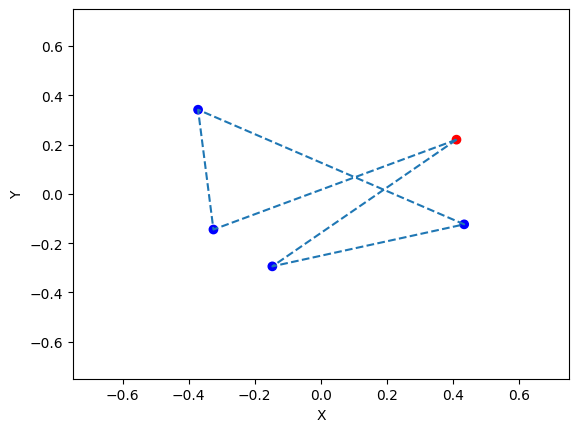

In [12]:
# test
gen = DataGenerator()
data = gen.train_batch(2,5,2)
idx = list(range(10))

gen.visualize_2D_trip(data[0])

---

# Training

### configuration and hyperparams

In [13]:
config = {
    'd_model': 128,
    'n_enc_layers': 4,
    'd_ff': 512,
    'n_enc_heads': 8,
    'd_query': 256,
    'd_attn': 256,
    'crit_hidden': 256,
    'n_history': 6,
    'p_dropout': 0.2,
    # log
    'proj_name': "attn-rl-tsp",
    'log_interval': 200,
    # train params
    'taining_steps': 20000,
    'batch_size': 256,
    'max_len': 60,
    'space_dim': 2,
    'model_path': "model.pt",
    'test': True,
    'test_steps': 5,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    # Optimizer
    'lr': 0.001,
    'lr_decay_rate': 0.99,
    'lr_decay_steps': 2000,
    'grad_clip': 1
}

In [14]:
def rewards_fn(coords:torch.Tensor, tour:torch.Tensor):
    """calculating rewards-to-go at each timestep.
    rewards-to-go is equal to the ditance ahead of the current position until the eand of tour.

    Args:
        `coords`: Tensor of size [batch_size, seq_len, dim],
            representing each city's coordinates.
        `tour`: Tensor of size [batch_size, seq_len + 1],
            representing the tour's indexes (comes back to the first city).

    Returns:
        float: Reward for this tour (negative tour length).
    """
    dim = coords.size(-1)
    ordered_coords = torch.gather(coords, 1, tour.long().unsqueeze(-1).repeat(1, 1, dim))
    ordered_coords = ordered_coords.transpose(0, 2)   # [dim, seq_len, batch_size]
    # For each dimension (x, y), compute the squared difference between each city
    squared_diff = [torch.square(d[1:] - d[:-1]).transpose(0, 1) for d in ordered_coords]

    # euclidian distance between each city
    inter_city_distances = torch.sqrt(sum(squared_diff))
    distance = inter_city_distances.sum(dim=-1)
    
    return distance.float()

class Trainer():
    def __init__(self, config, agent, dataset):
        super().__init__()
        self.config = config
        self.agent = agent
        self.dataset = dataset

        self.device = torch.device(self.config["device"])
        self.agent = self.agent.to(self.device)

        self.optim = torch.optim.Adam(params=self.agent.parameters(), lr=self.config["lr"])
        gamma = 1 - self.config["lr_decay_rate"] / self.config["lr_decay_steps"]      # To have same behavior as Tensorflow implementation
        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=self.optim, gamma=gamma)


    def train_step(self, data):
        self.optim.zero_grad()

        tour, crit_val, log_probs, _ = self.agent(data)
        # get reward
        reward = rewards_fn(data, tour)
        # compute losses
        actor_loss = ((reward - crit_val).detach() * log_probs).mean()
        critic_loss = F.mse_loss(reward, crit_val)
        # compute grads
        (actor_loss + critic_loss).backward()
        # clip grads
        nn.utils.clip_grad_norm_(self.agent.parameters(), self.config["grad_clip"])
        # update params
        self.optim.step()
        # decay lr
        self.scheduler.step()

        losses = [actor_loss, critic_loss]

        return reward.mean(), losses

    def train(self):
        self.agent.train()
        running_reward = 0
        running_actor_loss, running_critic_loss = 0, 0

        self.logs = {
                    'avg_reward': [],
                    'actor_loss': [],
                    'critic_loss': [],
                    'learning_rate': [],
                    'step': []
        }

        for step in range(self.config["taining_steps"]):
            log_intv = self.config["log_interval"]
            input_batch = self.dataset.train_batch(self.config["batch_size"], self.config["max_len"], self.config["space_dim"])
            input_batch = torch.Tensor(input_batch).to(self.device)

            reward, losses = self.train_step(input_batch)

            running_reward += reward
            running_actor_loss += losses[0]
            running_critic_loss += losses[1]

            if step % log_intv == 0 and step != 0:
                # Log stuff
                self.logs['avg_reward'].append(running_reward / log_intv)
                self.logs['actor_loss'].append(running_actor_loss / log_intv)
                self.logs['critic_loss'].append(running_critic_loss / log_intv)
                self.logs['learning_rate'].append(self.scheduler.get_last_lr()[0])
                self.logs['step'].append(step)
                print(
                    f">> Step {step+1} => actor_loss:\t{self.logs['actor_loss'][-1]:0.04f} |\tcritic_loss: {self.logs['critic_loss'][-1]:0.04f} |\tavg rewad: {self.logs['avg_reward'][-1]:0.04f}"
                )

                # reset running stats
                running_reward = 0
                running_actor_loss, running_critic_loss = 0, 0

In [15]:
config["device"]

device(type='cpu')

## train

In [ ]:
dataset = DataGenerator()

agent = Agent(
    space_dim=      config["space_dim"],
    d_model=        config["d_model"],
    n_enc_layers=   config["n_enc_layers"],
    d_ff=           config["d_ff"],
    n_enc_heads=    config["n_enc_heads"],
    d_query=        config["d_query"],
    d_attn=         config["d_attn"],
    crit_hidden=    config["crit_hidden"],
    n_history=      config["n_history"],
    p_dropout=      config["p_dropout"]
    )

trainer = Trainer(config, agent, dataset)
trainer.train()

# save trained agent
torch.save(agent.state_dict(), config["model_path"])


<ipython-input-11-f6a703f54090>:79: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  input_batch = torch.Tensor(input_batch).to(self.device)


>> Step 201 => actor_loss:	-429.9088 |	critic_loss: 63.5587 |	avg rewad: 18.4601
>> Step 401 => actor_loss:	-1.5316 |	critic_loss: 1.0529 |	avg rewad: 11.0845
>> Step 601 => actor_loss:	-1.5090 |	critic_loss: 1.0016 |	avg rewad: 10.8093
>> Step 801 => actor_loss:	-1.2984 |	critic_loss: 0.9907 |	avg rewad: 10.7263
>> Step 1001 => actor_loss:	-1.1664 |	critic_loss: 0.9799 |	avg rewad: 10.6668
>> Step 1201 => actor_loss:	-1.1857 |	critic_loss: 0.9958 |	avg rewad: 10.6195
>> Step 1401 => actor_loss:	-1.1489 |	critic_loss: 0.9784 |	avg rewad: 10.5932
>> Step 1601 => actor_loss:	-1.2442 |	critic_loss: 0.9778 |	avg rewad: 10.5727
>> Step 1801 => actor_loss:	-1.1006 |	critic_loss: 0.9806 |	avg rewad: 10.5451
>> Step 2001 => actor_loss:	-0.9877 |	critic_loss: 0.9681 |	avg rewad: 10.5109
>> Step 2201 => actor_loss:	-0.9544 |	critic_loss: 0.9702 |	avg rewad: 10.4943
>> Step 2401 => actor_loss:	-1.0457 |	critic_loss: 0.9587 |	avg rewad: 10.4890
>> Step 2601 => actor_loss:	-1.0044 |	critic_loss: 0.

# Evaluation

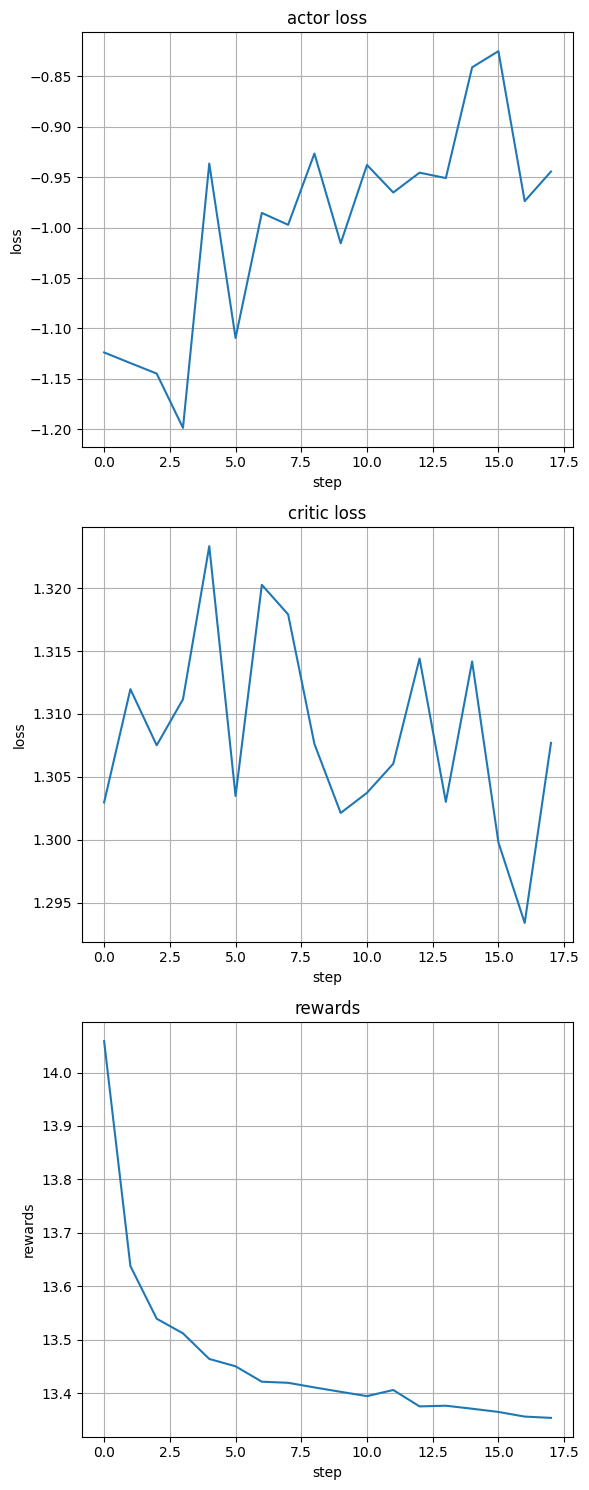

In [ ]:
plt.figure(figsize=(6,15))

plt.subplot(3,1,1)
plt.plot(list(range(len(trainer.logs["actor_loss"][2:]))), [i.cpu().item() for i in trainer.logs["actor_loss"][3:]])
plt.title("actor loss")
plt.xlabel("step")
plt.ylabel("loss")
plt.grid()

plt.subplot(3,1,2)
plt.plot(list(range(len(trainer.logs["critic_loss"][2:]))), [i.cpu().item() for i in trainer.logs["critic_loss"][3:]])
plt.title("critic loss")
plt.xlabel("step")
plt.ylabel("loss")
plt.grid()


plt.subplot(3,1,3)
plt.plot(list(range(len(trainer.logs["avg_reward"][2:]))), [i.cpu().item() for i in trainer.logs["avg_reward"][3:]])
plt.title("rewards")
plt.xlabel("step")
plt.ylabel("rewards")
plt.grid()

plt.tight_layout()


Agent Reward:	 12.523487091064453


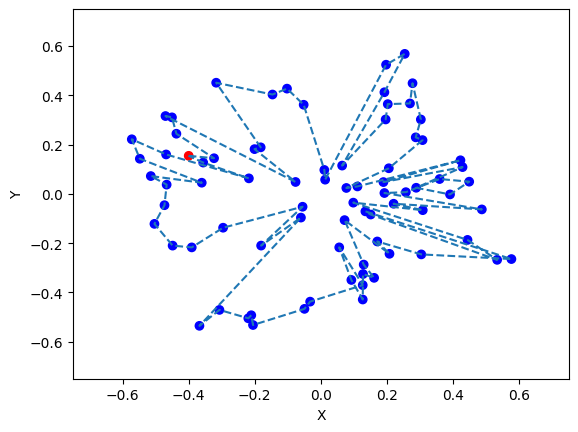

Opimal route:	 20.24913


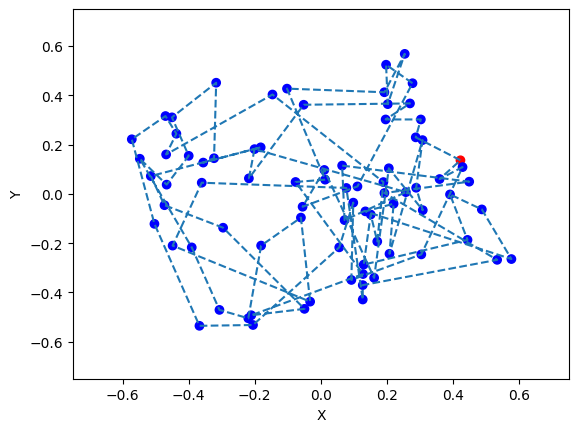



Agent Reward:	 11.112655639648438


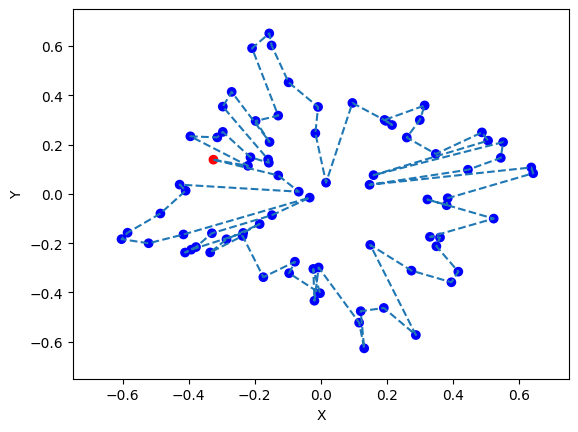

Opimal route:	 18.519144


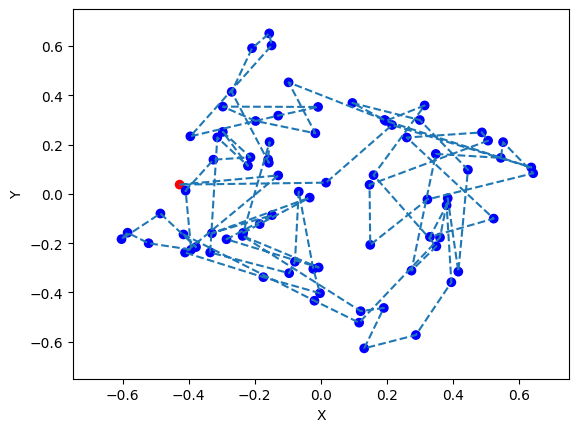



Agent Reward:	 12.230108261108398


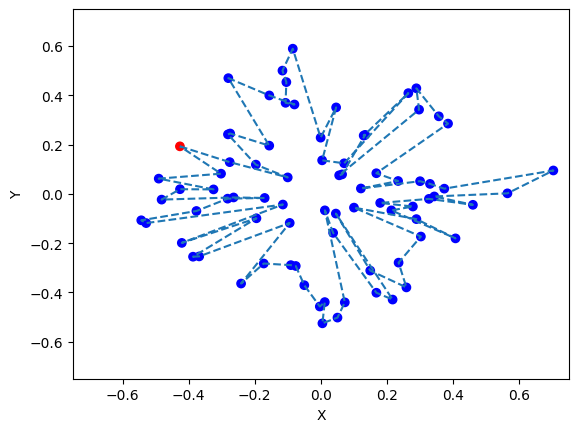

Opimal route:	 19.031757


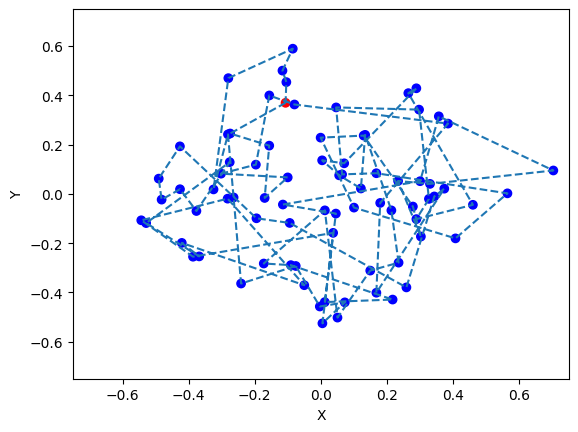

In [ ]:
device = torch.device(config["device"])
# Load trained agent
agent.load_state_dict(torch.load("/content/agent.pth"))
agent.eval()
agent = agent.to(device)

tours = []

running_reward = 0
for _ in range(2):
    input_batch = dataset.test_batch(config["batch_size"], config["max_len"], config["space_dim"], shuffle=False)
    input_batch = torch.Tensor(input_batch).to(device)

    tour, *_ = agent(input_batch)

    reward = rewards_fn(input_batch, tour)

    # Find best solution
    j = reward.argmin()
    best_agent_tour_idx = tour[j][:-1].tolist()
    best_agent_tour = input_batch.cpu()[j][best_agent_tour_idx,:]

    # TODO
    # Xs = input_batch.cpu().numpy()[j][:,0].copy()
    # Ys = input_batch.cpu().numpy()[j][:,1].copy()
    # solver = TSPSolver.from_data(Xs,Ys,norm="EUC_2D")
    # solution = solver.solve()
    # ps = solution.tour
    # opt_tour = input_batch.cpu().numpy()[j][ps,:].copy()
    # opt_reward = reward_(opt_tour)

    # Log
    running_reward += reward[j]

    tours.append(best_agent_tour)

    # Display
    print('Agent tour distance:\t', reward[j].item())
    dataset.visualize_2D_trip(best_agent_tour)
    # print('Opimal route:\t', opt_reward)
    # dataset.visualize_2D_trip(opt_tour)
    print("\n========================\n")

In [ ]:
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

def animate(frame,ax,steps_list):
    # ax.clear()
    step = steps_list[frame]
    x,y,dx,dy = step
    ax.arrow(x,y,dx,dy,alpha=0.8, color='purple',
        ls="--", lw=1.2, length_includes_head=True, head_width=.02, head_length=.04)

def animated_visualize_2D_trip(trip, opt_trip=None):  # Plot tour
    
    colors = ["red"]  # First city red
    for i in range(len(trip) - 1):
        colors.append("blue")

    if not opt_trip:
        fig, ax11 = plt.subplots(nrows=1, ncols=1)
        ax11.scatter(trip[:, 0], trip[:, 1], color=colors,s=15)  # Plot cities
        ax11.set_title("Agent")
        ax11.set_xlim(-0.75, 0.75)
        ax11.set_ylim(-0.75, 0.75)
        ax11.set_xlabel("X")
        ax11.set_ylabel("Y")
    else:
        fig, [ax11, ax12] = plt.subplots(nrows=1, ncols=2)
        ax11.scatter(trip[:, 0], trip[:, 1], color=colors,s=15)  # Plot cities
        ax12.scatter(opt_trip[:, 0], opt_trip[:, 1], color=colors,s=15)  # Plot cities

        # plotting optimal plot
        opt_tour = np.array(list(range(len(opt_trip))) + [0])  # Plot tour
        opt_X = opt_trip[opt_tour, 0]
        opt_Y = opt_trip[opt_tour, 1]
        for x,y,dx,dy in  zip(opt_X[:-1], opt_Y[:-1], opt_X[1:] - opt_X[:-1], opt_Y[1:]- opt_Y[:-1]):
            ax12.arrow(x,y,dx,dy, alpha=0.8, color='green',
                ls="--", lw=1.2, length_includes_head=True, head_width=.02, head_length=.04)
        ax11.set_title("Agent")
        ax12.set_title("Optimal Solution (by Concorde solver)")
        ax11.set_xlim(-0.75, 0.75)
        ax12.set_xlim(-0.75, 0.75)
        ax11.set_ylim(-0.75, 0.75)
        ax12.set_ylim(-0.75, 0.75)
        ax11.set_xlabel("X")
        ax12.set_xlabel("X")
        ax11.set_ylabel("Y")
        ax12.set_ylabel("Y")
    
    # fig.set_size_inches(20,5)
    # fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    # animating agent's plot
    tour = np.array(list(range(len(trip))) + [0])  # Plot tour
    X = trip[tour, 0]
    Y = trip[tour, 1]
    steps_list=[]
    for x,y,dx,dy in  zip(X[:-1], Y[:-1], X[1:]-X[:-1], Y[1:]-Y[:-1]):
        steps_list.append((x,y,dx,dy))

    ani = FuncAnimation(fig, lambda frame: animate(frame, ax11, steps_list), frames=len(steps_list), interval=100, repeat=False)
    # Save the animation as an animated GIF
    ani.save("tour.gif", dpi=500, writer=PillowWriter(fps=3))
    plt.show()
    plt.close()


In [ ]:
# test
gen = DataGenerator()
data = gen.train_batch(2,80,2)
idx = list(range(10))
test_route = data[0]



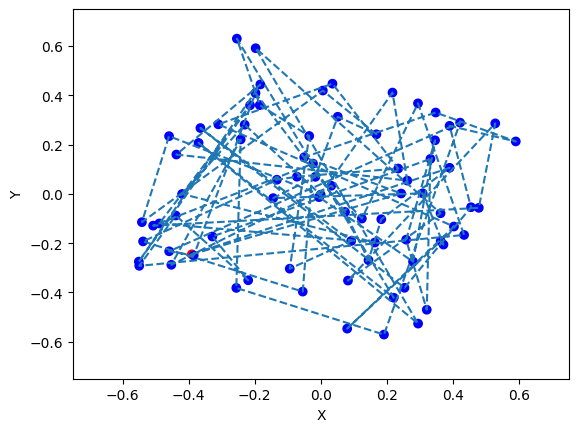

In [ ]:
gen.visualize_2D_trip(test_route)

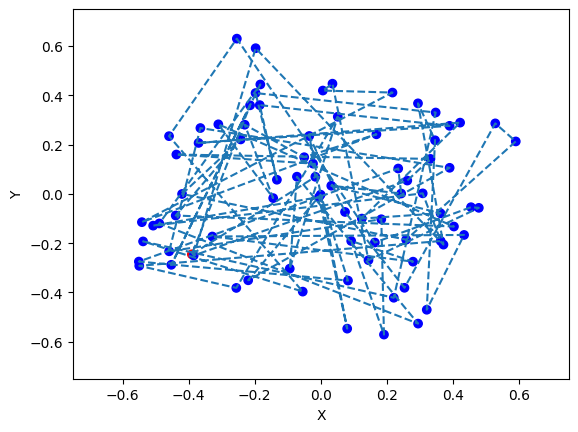

In [ ]:
gen.visualize_2D_trip(test_route[ps,:])

In [ ]:
Xs = test_route[:,0]
Ys = test_route[:,1]
Xs

array([-0.39039302,  0.38929038,  0.18263772,  0.14392307,  0.07294498,
       -0.1976731 , -0.38468923, -0.45891215,  0.42096131,  0.19074501,
       -0.25583885, -0.24263006, -0.45237857,  0.03135905,  0.12383321,
        0.29360131,  0.43299843, -0.54935336, -0.43906942, -0.21991674,
       -0.32830013,  0.33129547,  0.32013361,  0.25782832,  0.34517282,
        0.27861288, -0.00584116,  0.21648147,  0.26125515, -0.4371097 ,
       -0.18318105, -0.55055277, -0.21424272, -0.48876741,  0.16308246,
       -0.4198425 , -0.23046211, -0.00078015, -0.45923141, -0.54133703,
        0.00587994,  0.16791341,  0.05105232, -0.01678125, -0.14430119,
        0.30788132,  0.37063138,  0.3623613 ,  0.07952256,  0.40233038,
       -0.31018324,  0.03497396,  0.23383817, -0.07243914, -0.13308145,
       -0.53776791, -0.05495923, -0.02383669, -0.50730127,  0.47757734,
        0.52729994,  0.08187504,  0.3618744 , -0.19736437,  0.29390887,
       -0.36991226,  0.22040205, -0.25420178, -0.1849882 , -0.03

In [ ]:
solver = TSPSolver.from_data(Xs[ps],Ys[ps],norm="EUC_2D")
solution = solver.solve()
ps = solution.tour
opt_reward = solution.optimal_value

In [ ]:
ps

array([ 0, 43, 57, 29, 21, 28,  6, 63, 46, 15, 24, 22, 16, 20, 25, 71,  9,
        2,  7, 72,  1, 19, 37, 61, 31, 52, 79, 13, 62, 14,  8, 65, 75, 68,
       54,  5, 77, 66, 55, 56, 38, 67, 34, 74, 59,  3, 51, 40, 27, 39, 41,
       78, 36, 44, 50, 49, 18, 11, 35, 23, 76, 60, 73,  4, 69, 48, 26, 58,
       45, 47, 17, 10, 42, 70, 53, 64, 33, 30, 12, 32], dtype=int32)

In [ ]:
print(test_route,"\n")
print(test_route[ps,:])

[[-0.31555498 -0.21319426]
 [-0.0009329   0.01399095]
 [ 0.21048914  0.25608929]
 [ 0.54557131 -0.11795916]
 [-0.29262949  0.12533785]
 [ 0.18748406  0.28919842]
 [-0.4283401  -0.04957865]
 [-0.22352992  0.0703133 ]
 [ 0.62809222 -0.20891432]
 [-0.31064933 -0.16528342]] 

[[-0.31555498 -0.21319426]
 [-0.31064933 -0.16528342]
 [ 0.54557131 -0.11795916]
 [ 0.62809222 -0.20891432]
 [ 0.21048914  0.25608929]
 [ 0.18748406  0.28919842]
 [-0.0009329   0.01399095]
 [-0.29262949  0.12533785]
 [-0.4283401  -0.04957865]
 [-0.22352992  0.0703133 ]]
